In [113]:
import sys
import pythoncyc as pc
import csv
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/home/stef/Tb/reaction_mapping')
from utils import save_json, load_json, sanitize
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import itertools
import requests
from collections import Counter, defaultdict
m2s = Chem.MolToSmiles
s2m = Chem.MolFromSmiles
import pandas as pd
from mapping.mapping_fcns import match_template

smi2paired = load_json('../mapping/smi2paired_cof.json')
smi2unpaired = load_json('../mapping/smi2unpaired_cof.json')
smi2paired = {tuple(k.split(',')):v[0].split(',') for k,v in smi2paired.items()}

# Analyze mapping performance

In [2]:
# Load reactions and EC numbers

# Settings
filtered_mc_path = '../mapping/mc_v21_as_is.json' # mc_rxns_final_221214.json
using_jos_rxns = True # Whether or not to alter rxn ids to fit jos

# Read in ec numbers saved from mc
rxns_wo_ec = []
with open('mc_wo_ec.csv', 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
            rxns_wo_ec.append(row[0])

rxns_w_ec = load_json('mc_ec.json')

print(len(list(rxns_w_ec.keys())) / (len(list(rxns_w_ec.keys())) + len(rxns_wo_ec)))

# Modify ec lists with reversed reaction ids
filtered_mc_rxns = load_json(filtered_mc_path)
filtered_rxns_w_ec = {}
filtered_rxns_wo_ec = []

if using_jos_rxns:
    for k,v in filtered_mc_rxns.items():
        if '|' + k.rstrip('_reverse') + '|' in rxns_wo_ec:
            filtered_rxns_wo_ec.append(k)
        elif '|' + k.rstrip('_reverse') + '|' in rxns_w_ec.keys():
            filtered_rxns_w_ec[k] = rxns_w_ec['|' + k.rstrip('_reverse') + '|']
else:
    for k,v in filtered_mc_rxns.items():
        if k.rstrip('_REV|') + '|' in rxns_wo_ec:
            filtered_rxns_wo_ec.append(k)
        elif k.rstrip('_REV|') + '|' in rxns_w_ec.keys():
            filtered_rxns_w_ec[k] = rxns_w_ec[k.rstrip('_REV|') + '|']

print(len(list(filtered_rxns_w_ec.keys())) / len(filtered_mc_rxns))

0.7913456141246109
0.8429842076601924


In [3]:
# Load in all rule names
rules_path = '../mapping/minimal1224_all_uniprot.tsv' # JN3604IMT_rules.tsv
all_rules = []
with open(rules_path, 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        all_rules.append(row[0])

all_rules = all_rules[1:]
rule_df = pd.read_csv(rules_path, delimiter='\t')
rule_df.set_index('Name', inplace=True)

In [4]:
# Load mapping
suffix = '_mc_v21_min_rules_enforce_cof.csv' # _mc_221214_imt_rules_enforce_cof.csv 
mapping_path = '../mapping/results/mapping' + suffix
missing_path = '../mapping/results/missing_smiles' + suffix
parse_path = '../mapping/results/smiles_parse_issues' + suffix
all_rxns = []
mapped_rxns = []
unmapped_rxns = []
missing_smiles = []
parse_issues  = []
rxn2rule = {}

with open(mapping_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        all_rxns.append(row[0])
        if len(row) == 1:
            unmapped_rxns.append(row[0])
            rxn2rule[row[0]] = []
        else:
            mapped_rxns.append(row[0])
            rxn2rule[row[0]] = row[1:]

# Load list of reactions missing smiles
with open(missing_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        missing_smiles.append(row[0])

# Load those with unparseable smiles
with open(parse_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        parse_issues.append(row[0])

print("Mapping fraction: {}".format(len(mapped_rxns) / len(all_rxns)))
print("Total # reactions analyzed: {}".format(len(all_rxns)))

Mapping fraction: 0.8282079443529197
Total # reactions analyzed: 21852


## Break down by EC

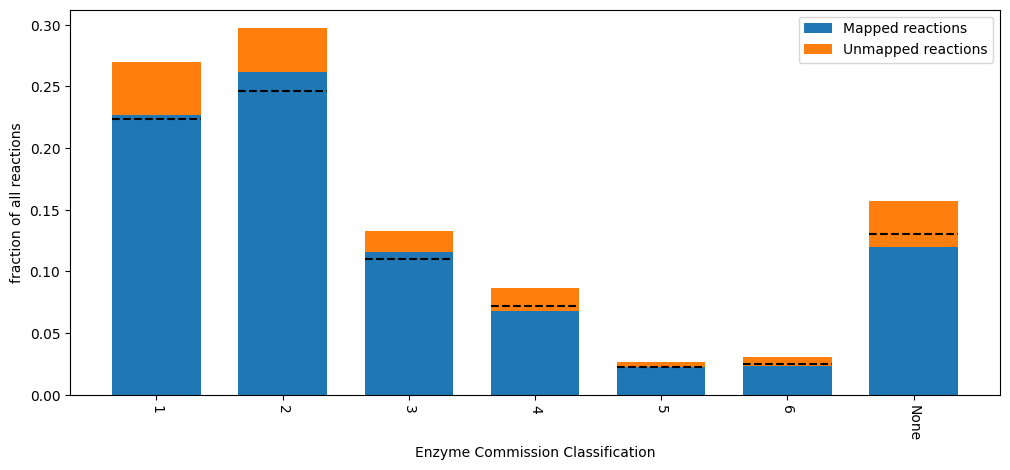

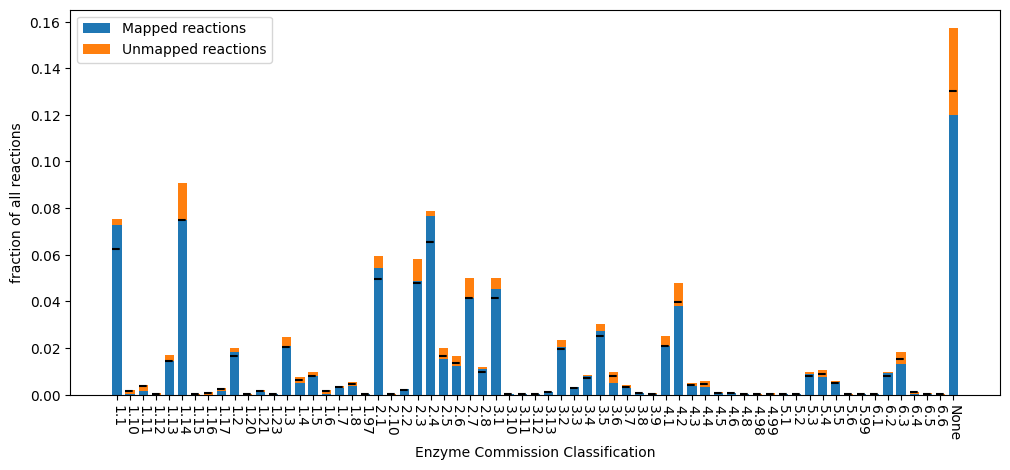

In [5]:
map_frac = len(mapped_rxns) / len(all_rxns)

# Counts by EC. Sublists correspond mapped, unmapped
# dicts from left to right are 1st digit, 2nd digit ec
# keys in dicts are ec #
ecc_arrs = [[{}, {}], [{}, {}]]
ec_to_rxn = [[{}, {}], [{}, {}]] # Same structure as ecc_arrs but tracks rxn ids, not counts
for i, arr in enumerate([mapped_rxns, unmapped_rxns]): # Iterate over mapped, unmapped lists
    for elt in arr: # Iterate over rxn ids in both lists

        if elt in filtered_rxns_w_ec.keys():
            this_ecc = filtered_rxns_w_ec[elt]
            this_ecc = this_ecc[0].lstrip('|EC-').rstrip('|').split('.')
            ecc1 = this_ecc[0]
            if ecc1 != '7': # Catch a few remaining tranport reactions

                # Catch entries with 1st but not
                # second digit ec... kludgy but ok for now
                if len(this_ecc) > 1:
                    ecc2 = ecc1 + '.' + this_ecc[1]
                else:
                    ecc2 = 'None'

                if ecc1 not in ecc_arrs[i][0]:
                    ecc_arrs[i][0][ecc1] = 1
                    ec_to_rxn[i][0][ecc1] = [elt]
                else:
                    ecc_arrs[i][0][ecc1] += 1
                    ec_to_rxn[i][0][ecc1].append(elt)

                if ecc2 not in ecc_arrs[i][1]:
                    ecc_arrs[i][1][ecc2] = 1
                    ec_to_rxn[i][1][ecc2] = [elt]
                else:
                    ecc_arrs[i][1][ecc2] += 1
                    ec_to_rxn[i][1][ecc2].append(elt)
        else:
            if 'None' not in ecc_arrs[i][0]:
                ecc_arrs[i][0]['None'] = 1
                ec_to_rxn[i][0]['None'] = [elt]
            else:
                ecc_arrs[i][0]['None'] += 1
                ec_to_rxn[i][0]['None'].append(elt)

            if 'None' not in ecc_arrs[i][1]:
                ecc_arrs[i][1]['None'] = 1
                ec_to_rxn[i][1]['None'] = [elt]
            else:
                ecc_arrs[i][1]['None'] += 1
                ec_to_rxn[i][1]['None'].append(elt)

ec_1st_union = list(set(ecc_arrs[0][0].keys()) | set(ecc_arrs[1][0].keys()))
ec_2nd_union = list(set(ecc_arrs[0][1].keys()) | set(ecc_arrs[1][1].keys()))
for elt in ecc_arrs:
    for k in ec_1st_union:
        if k not in elt[0].keys():
            elt[0][k] = 0

    for k in ec_2nd_union:
        if k not in elt[1].keys():
            elt[1][k] = 0


# Make two plots
labels = ['Mapped reactions', 'Unmapped reactions']
width = 0.7
ymax = [0.55, 0.35]
for i in range(2): # Iterate over 2 levels of ecc
    fig, ax = plt.subplots(figsize=(12,5))
    tot = sum(list(ecc_arrs[0][i].values())) + sum(list(ecc_arrs[1][i].values()))
    

    for j in range(2): # Iterate over mapped, unmapped
        xs = np.arange(len(ecc_arrs[j][i]))
        names = sorted(list(ecc_arrs[j][i].keys()))
        values = np.array([ecc_arrs[j][i][name] for name in names])
        values = values / tot

        if j == 0:
            ax.bar(xs, values, width=width, tick_label=names, label=labels[j])
            last_names = names
            last_values = values
        else:
            ax.bar(xs, values, width=width, tick_label=names, label=labels[j], bottom=last_values)
            ax.set_xticklabels(names, rotation=-90)
        
    # Make chance lines
    for k, x in enumerate(xs):
        top = last_values[k] + values[k]
        ax.hlines(top * map_frac, x - width / 2, x + width / 2, color='k', ls='--')
        # ax.hlines(top * jos_overall_map_frac, x - width / 2, x + width / 2, color='g', ls='--')
    
    # ax.set_ylim(0, ymax[i])
    ax.set_xlabel(f"Enzyme Commission Classification")
    ax.set_ylabel('fraction of all reactions')
    ax.legend()
    plt.show()

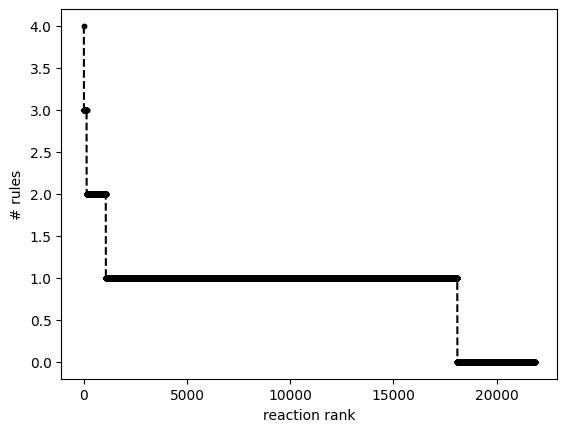

In [6]:
# Plot rule counts by reaction (on most specific level available)
n_rules_per_rxn = sorted([len(elt) for elt in rxn2rule.values()], reverse=True)
fig, ax = plt.subplots()
ax.plot(np.arange(1, len(n_rules_per_rxn) + 1), n_rules_per_rxn, 'k.--')
ax.set_xlabel('reaction rank')
ax.set_ylabel('# rules')
plt.show()

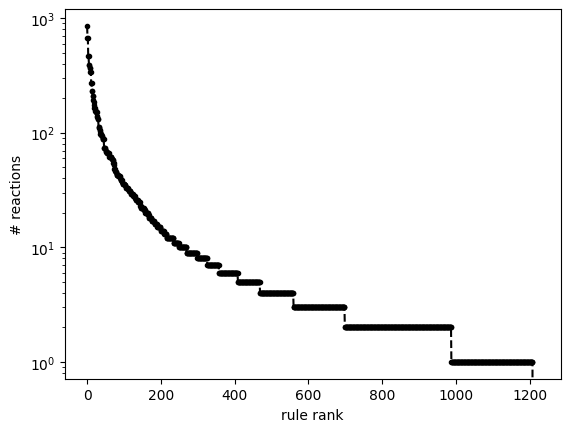

Mean rxns mapped: 15.765522875816993


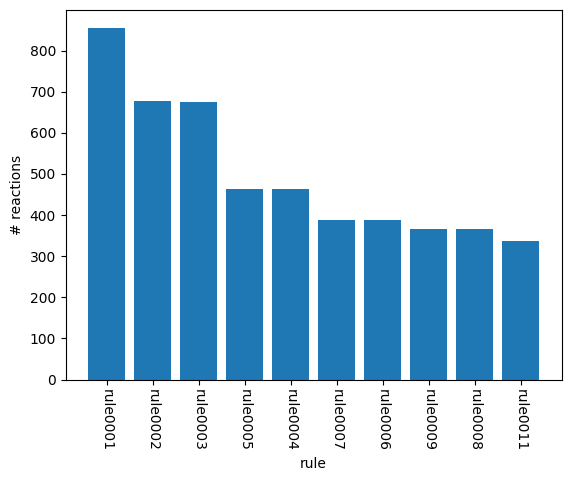

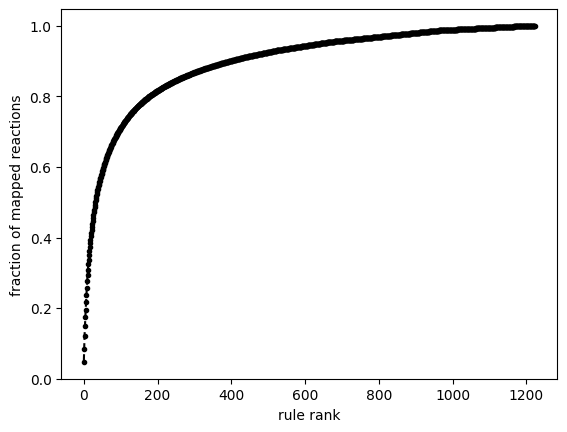

178


In [7]:
# Plot reaction counts by rule
rule2rxn = {}
for k,v in rxn2rule.items():
    for elt in v:
        if elt not in rule2rxn:
            rule2rxn[elt] = [k]
        else:
            rule2rxn[elt].append(k)

rule_ids = list(rule2rxn.keys())
n_rxns_by_rule = [len(elt) for elt in rule2rxn.values()]
rules_rxn_ct_sorted = [[elt[1], elt[0]] for elt in sorted(zip(n_rxns_by_rule, rule_ids), reverse=True)]

# Find rules not in mapping
for elt in all_rules:
    if elt not in rule_ids:
        rules_rxn_ct_sorted.append([elt, 0]) # Tack on with n_rxns=0

rules, rxn_cts = list(zip(*rules_rxn_ct_sorted)) # Sort cts and rule names together

# Order rules by those that contribute the maximum
# number of "new" reactions to the mapping pool as possible
mapping_pool = set()
max_delta_sorted = [] # Reactions sorted by contribution to the mapping pool
deltas = []
search_space = all_rules.copy()

# Go until you've gotten all the rules
while len(max_delta_sorted) < len(all_rules):
    best_contribution = set()
    best_delta = 0
    # Iterate over search space to find max contribution
    for elt in search_space:
        if elt in rule2rxn.keys():
            this_rxns = set(rule2rxn[elt])
        else:
            this_rxns = set()

        this_contribution = this_rxns - mapping_pool # In this rxns but not pool
        this_delta = len(this_contribution)
        if this_delta >= best_delta:
            best_contribution = this_contribution
            best_delta = this_delta
            best_id = elt

    # Update pool
    mapping_pool = mapping_pool | best_contribution
    deltas.append(best_delta)
    max_delta_sorted.append(best_id)
    search_space.remove(best_id) # Reduce search space by the rule you got

rxn_ct_cdf = np.cumsum(deltas) / len(mapped_rxns)
eighty_percent = np.where(np.array(rxn_ct_cdf) > 0.8)[0][0]

# Plot all cts w/o rule names
fig, ax = plt.subplots()
ax.plot(rxn_cts, 'k.--')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlabel('rule rank')
ax.set_ylabel('# reactions')
plt.show()
print("Mean rxns mapped: {}".format(sum(rxn_cts) / len(rxn_cts)))

# Plot top n rules
n = 10
fig, ax = plt.subplots()
ax.bar(np.arange(n), rxn_cts[:n], tick_label=rules[:n])
ax.set_xticklabels(rules[:n], rotation=-90)
ax.set_xlabel('rule')
ax.set_ylabel('# reactions')
plt.show()

# Plot cumulative distr
fig, ax = plt.subplots()
ax.plot(rxn_ct_cdf, 'k.--')
ax.set_xlabel('rule rank')
ax.set_ylabel('fraction of mapped reactions')
plt.show()
print(eighty_percent)

In [ ]:
# Intermediate only

unused = rules[rxn_cts.index(0):]
unused_min = {}
for elt in unused:
    k = elt.split('_')[0]
    if k not in unused_min:
        unused_min[k] = 1
    else:
        unused_min[k] += 1

zipped_rules = [*unused_min.items()]
rezipped_rules = list(zip(list(zip(*zipped_rules))[1], list(zip(*zipped_rules))[0])) 

rule_name, imt_unused_cts = list(zip(*[(elt[1], elt[0]) for elt in sorted(rezipped_rules, reverse=True)]))

In [ ]:
# Intermediate rules only!
# Re-do rule cts by reaction with general
# rule ids

# Make dict with rule cts per reaction
# described only by the general rule id
gen_imt_rxn_by_rule = np.zeros(shape=(len(all_rxns), len(all_rules)))

for i,id in enumerate(all_rxns):
    this_rxn_rules = rxn2rule[id]
    this_ct = [0 for j in range(len(all_rules))]
    for elt in this_rxn_rules:
        idx = int(elt.lstrip('rule').split('_')[0])
        this_ct[idx] += 1
    gen_imt_rxn_by_rule[i,:] = this_ct
    
rxn_idxs, rule_idxs = np.where(gen_imt_rxn_by_rule > 1)
print(len(rxn_idxs))

522


# Compare with josephs mapping

In [8]:
# Load josephs original reaction data w/ mapping assignments
jos_rxns = load_json('../jos_rxn_data/metacyc.json')

In [9]:
# Jos mapfrac
jos_mapped = {}
jos_unmapped = []
for elt in all_rxns:
    if jos_rxns[elt][-1] != 'Unmapped':
        jos_mapped[elt] = jos_rxns[elt][-1]
    else:
        jos_unmapped.append(elt)

jos_overall_map_frac = len(jos_mapped) / len(all_rxns)
print(jos_overall_map_frac)

# Get reactions that jos mapped but I missed
missed = []
for elt in all_rxns:
    if (len(rxn2rule[elt]) == 0) & (jos_rxns[elt][-1] != 'Unmapped'):
        missed.append(elt)

0.8334706205381659


In [10]:
tp = list(set(mapped_rxns) & set(jos_mapped)) # True positives
fp = list(set(mapped_rxns) & set(jos_unmapped)) # False positives
fn = list(set(unmapped_rxns) & set(jos_mapped)) # Missed / false negatives
tn = list(set(unmapped_rxns) & set(jos_unmapped)) # True negatives

print("True positives: {}, False positives: {}, False negatives: {}, True negatives: {}".format(len(tp), len(fp), len(fn), len(tn)))
print("Sensitivity: {}, Specificity: {}".format(len(tp) / (len(tp) + len(fn)), len(tn) / (len(tn) + len(fp))))

True positives: 18060, False positives: 38, False negatives: 153, True negatives: 3601
Sensitivity: 0.9915994070169659, Specificity: 0.9895575707611981


In [22]:
# Look at mismatches in mapped reactions

mismatch = []
for elt in tp:
    jo = jos_rxns[elt][-1]
    me = rxn2rule[elt]
    if jo not in me:
        mismatch.append([elt, me, jo])

print(len(mismatch))

# Look at how many mismatches have same smarts, so
# are just a matter of different cofactors presumably
i=0
for elt in mismatch:
    if rule_df.loc[elt[1][0], "SMARTS"] != rule_df.loc[elt[2], "SMARTS"]:
        i+=1
        print(elt)
        print(rule_df.loc[elt[1][0], "SMARTS"], rule_df.loc[elt[1][0], "Reactants"])
        print(rule_df.loc[elt[2], "SMARTS"], rule_df.loc[elt[2], "Reactants"])
print(i)

# 0 mismatches have different smarts...

32
0


In [31]:
# The mismatch is caused by me mapping things to
# cofactors that Joseph calls "Any" (doesn't map to cofactor)

mismatch_rules = list(set([(elt[1][0], elt[2]) for elt in mismatch]))
print(mismatch_rules)
for elt in mismatch_rules:
    print(rule_df.loc[elt[0], ["Reactants", 'Products']].to_list())
    print(rule_df.loc[elt[1], ["Reactants", 'Products']].to_list())

[('rule0033', 'rule0205'), ('rule0034', 'rule0206'), ('rule0030', 'rule0065'), ('rule0031', 'rule0065')]
['METHYL_ACCEPTOR_CoF;Any', 'METHYL_DONOR_CoF;Any']
['Any;Any', 'Any;Any']
['METHYL_DONOR_CoF;Any', 'METHYL_ACCEPTOR_CoF;Any']
['Any;Any', 'Any;Any']
['Any;CARBONYL_CoF', 'AMINO_CoF;Any']
['Any;Any', 'Any;Any']
['AMINO_CoF;Any', 'Any;CARBONYL_CoF']
['Any;Any', 'Any;Any']


In [133]:
cof_class2mol = defaultdict(list)
anys = defaultdict(list)
for elt in mismatch:
    test_rxn_id = elt[0]
    test_rule = elt[1][0]
    test_rxn = [sanitize(list(subelt.values())) for subelt in jos_rxns[test_rxn_id][:2]]
    test_rxn_names = [list(subelt.keys()) for subelt in jos_rxns[test_rxn_id][:2]]
    test_react_template, test_prod_template = rule_df.loc[test_rule, ["Reactants", 'Products']].to_list()
    match_idxs = match_template(test_rxn, test_react_template, test_prod_template, smi2paired, smi2unpaired)
    test_react_template = test_react_template.split(';')
    if (len(match_idxs) == 1):

        matched_reactants = [test_rxn_names[0][idx] for idx in match_idxs[0]]

        for i, subelt in enumerate(test_react_template):
            if subelt != 'Any':
                cof_class2mol[subelt].append(matched_reactants[i][:-2])
            else:
                anys[matched_reactants[i][:-2]].append(test_rxn_id)

temp = {}
for k,v in cof_class2mol.items():
    temp[k] = list(set(v))

cof_class2mol = temp

temp = {}
for k,v in anys.items():
    temp[k] = list(set(v))

anys = temp

In [135]:
# The things I am mapping to cofactors
# seem to make sense
cof_class2mol

{'AMINO_CoF': ['D-ALANINE',
  'D-GLT',
  'L-ASPARTATE',
  'MET',
  'Amino-Acids',
  'L-Amino-Acids'],
 'CARBONYL_CoF': ['PYRUVATE',
  'CPD-479',
  '2-Oxo-carboxylates',
  '2-Oxo-Acids',
  'OXALACETIC_ACID',
  '2-KETOGLUTARATE'],
 'METHYL_ACCEPTOR_CoF': ['CPD-7670'],
 'METHYL_DONOR_CoF': ['TRIMETHYLSULFONIUM']}

In [139]:
fn_rules = [[elt, jos_rxns[elt][-1]] for elt in fn]
fp_rules = [[elt, rxn2rule[elt][0]] for elt in fp]


In [149]:
# My false positives include rule templates
# with Anys and cofactors. So I could be assigning
# substrates to cofactors that I shouldn't be or missing ones
for elt in fp_rules:
    print(elt, rule_df.loc[elt[1], ["Reactants", 'Products']].to_list())

['FADSYN-RXN_reverse', 'rule0037'] ['PPI;Any', 'Any;Any']
['RXN-18504', 'rule0033'] ['METHYL_ACCEPTOR_CoF;Any', 'METHYL_DONOR_CoF;Any']
['RXN-18506', 'rule0017'] ['Any;Pi', 'WATER;Any']
['RXN-18509_reverse', 'rule0174'] ['Any;O2', 'Any;WATER']
['RXN-12144', 'rule0069'] ['Any;Any', 'Any;Any']
['RXN-18511_reverse', 'rule0037'] ['PPI;Any', 'Any;Any']
['NUCLEOTIDE-PYROPHOSPHOKINASE-RXN_reverse', 'rule0473'] ['Any;PYROPHOSPHATE_DONOR_CoF', 'PYROPHOSPHATE_ACCEPTOR_CoF;Any']
['RXN-8704_reverse', 'rule0576'] ['Any;Any;O2', 'Any;Any;WATER;WATER']
['RXN-16839_reverse', 'rule0384'] ['Any;Any', 'Any;Any']
['RXN-7601', 'rule0033'] ['METHYL_ACCEPTOR_CoF;Any', 'METHYL_DONOR_CoF;Any']
['RIBOFLAVIN-PHOSPHOTRANSFERASE-RXN', 'rule0029'] ['Any;Any', 'Any;Any']
['RXN0-1321', 'rule0069'] ['Any;Any', 'Any;Any']
['RXN-9360_reverse', 'rule0248'] ['Any;CO2;PPI', 'Any;Any']
['RXN-3102_reverse', 'rule0576'] ['Any;Any;O2', 'Any;Any;WATER;WATER']
['RXN-9296_reverse', 'rule0015'] ['Any;PHOSPHATE_DONOR_CoF', 'PHOSPHA

In [143]:
cof_class2mol = defaultdict(list)
anys = defaultdict(list)
for elt in fp_rules:
    test_rxn_id = elt[0]
    test_rule = elt[1]

    test_rxn = [sanitize(list(subelt.values())) for subelt in jos_rxns[test_rxn_id][:2]]
    test_rxn_names = [list(subelt.keys()) for subelt in jos_rxns[test_rxn_id][:2]]
    test_react_template, test_prod_template = rule_df.loc[test_rule, ["Reactants", 'Products']].to_list()
    match_idxs = match_template(test_rxn, test_react_template, test_prod_template, smi2paired, smi2unpaired)
    test_react_template = test_react_template.split(';')
    if (len(match_idxs) == 1):

        matched_reactants = [test_rxn_names[0][idx] for idx in match_idxs[0]]

        for i, subelt in enumerate(test_react_template):
            if subelt != 'Any':
                cof_class2mol[subelt].append(matched_reactants[i][:-2])
            else:
                anys[matched_reactants[i][:-2]].append(test_rxn_id)

temp = {}
for k,v in cof_class2mol.items():
    temp[k] = list(set(v))

cof_class2mol = temp

temp = {}
for k,v in anys.items():
    temp[k] = list(set(v))

anys = temp

In [144]:
# Again, my cofactor labellings make sense
cof_class2mol

{'PPI': ['PPI'],
 'METHYL_ACCEPTOR_CoF': ['ADENOSYL-HOMO-CYS'],
 'Pi': ['Pi'],
 'O2': ['OXYGEN-MOLECULE'],
 'PYROPHOSPHATE_DONOR_CoF': ['ATP'],
 'CO2': ['CARBON-DIOXIDE'],
 'PHOSPHATE_DONOR_CoF': ['CTP', 'ATP'],
 'NAD_CoF': ['NADP', 'NAD-P-OR-NOP'],
 'H2O2': ['HYDROGEN-PEROXIDE'],
 'METHYL_DONOR_CoF': ['S-ADENOSYLMETHIONINE'],
 'NADH_CoF': ['NADH-P-OR-NOP'],
 'WATER': ['WATER'],
 'PYROPHOSPHATE_ACCEPTOR_CoF': ['AMP']}

In [146]:
'''
Things that I may be missing?

- FAD correctly not labeled in this case bc it is not w its
electron carrier pair here... it is being synthesized

- Think it's ok to not have those flavins?? (roseoflavin, roseoflavin 5-phosphate,
8-demethyl roseoflavin ) My list of pair names does not have them

- Missing (nucleoside-monophosphates, 5-phosphonucleoside-3-diphosphate) pair from lookup
and should have per jos list. In other words... I am not mapping these but their
names are in the list

- Should I have (caffeine, paraxanthine) as methyl donor/acceptor? They are not in the list

- CPD-12121 (dodeca) just losing a phosphate... fine to not have. It's not a a donor/acceptor

- Riboflavin to FMN is a phosphorylation.. dont think people think of these as donor/acceptor?

- Missing (riboflavin, reduced riboflavin) But not in list... feel like I should have this tho

- Missing (2-hydroxy-dATP, 2-hydroxy-dAMP) and def should have under ppi d/a. Names are in the list
'''

anys

{'FAD': ['FADSYN-RXN_reverse', 'FAD-PYROPHOSPHATASE-RXN_reverse'],
 'CPD-19833': ['RXN-18510_reverse', 'RXN-18504'],
 'CPD-19835': ['RXN-18505_reverse', 'RXN-18506'],
 'FMN': ['RXN-18509_reverse'],
 'CPD-19840': ['RXN-18511_reverse'],
 'Nucleoside-Monophosphates': ['NUCLEOTIDE-PYROPHOSPHOKINASE-RXN_reverse'],
 '1-3-7-TRIMETHYLXANTHINE': ['RXN-13106_reverse', 'RXN-7601'],
 'CPD-12121': ['RXN-9360_reverse'],
 'RIBOFLAVIN': ['RIBOFLAVINKIN-RXN_reverse', 'RXN-9296_reverse', 'RXN0-5187'],
 'CPD-316': ['NADPH-DEHYDROGENASE-FLAVIN-RXN_reverse', 'RXN-12445_reverse'],
 'CPD-12483': ['RXN-11520_reverse'],
 'CPD-12119': ['RXN-9358_reverse'],
 '7-METHYLXANTHINE': ['RXN-7600_reverse'],
 'CPD-14310': ['RXN-13335'],
 'CPD-12122': ['RXN-9365_reverse'],
 '5-PHOSPHONUCLEOSIDE-3-DIPHOSPHATE': ['NUCLEOTIDE-PYROPHOSPHOKINASE-RXN'],
 'CPD-12120': ['RXN-9359_reverse'],
 'CPD-19838': ['RXN-18509'],
 'CPD-13851': ['RXN0-6957_reverse'],
 'CPD-13852': ['RXN0-6957']}

In [161]:
# Organize false negatives by rule that jos gave them

fn_rule2rxns = defaultdict(list)
for elt in fn_rules:
    fn_rule2rxns[elt[1]].append(elt[0])

for k,v in fn_rule2rxns.items():
    print(k, v)
len(fn_rule2rxns)

rule0031 ['2.6.1.60-RXN', 'SERINE-GLYOXYLATE-AMINOTRANSFERASE-RXN', 'RXN-2205_reverse', 'RXN-14147_reverse', '2.6.1.41-RXN_reverse', 'BRANCHED-CHAINAMINOTRANSFERVAL-RXN_reverse', 'SERINE--PYRUVATE-AMINOTRANSFERASE-RXN', 'BRANCHED-CHAINAMINOTRANSFERILEU-RXN', 'SERINE--GLYOXYLATE-AMINOTRANSFERASE-RXN', '2-AMINOHEXANOATE-AMINOTRANSFERASE-RXN', '2.6.1.57-RXN', 'ASPAMINOTRANS-RXN', 'RXN-13697', 'METHIONINE--GLYOXYLATE-TRANSAMINASE-RXN_reverse', 'ALANINE--OXO-ACID-AMINOTRANSFERASE-RXN_reverse', 'VALINE-PYRUVATE-AMINOTRANSFER-RXN_reverse', 'BRANCHED-CHAINAMINOTRANSFERLEU-RXN', '2.6.1.14-RXN', '2.6.1.35-RXN_reverse', 'ASPAROXO-RXN', 'R15-RXN_reverse', 'RXN-974']
rule0467 ['RXN-15740_reverse', 'RXNI-3_reverse']
rule0095 ['RXN-11367_reverse', 'RXN-15739_reverse', 'RXN-15609_reverse', 'RXN-15621_reverse', 'RXN-14419_reverse']
rule0166 ['L-AMINO-ACID-DEHYDROGENASE-RXN', 'RXN-13184_reverse', 'ILEDEAMINE-RXN', 'VALINE-DEHYDROGENASE-NADP+-RXN_reverse', 'LEUCINE-DEHYDROGENASE-RXN', '1.4.1.21-RXN', 'SE

44

In [178]:
# Split up into rules that I never mapped
# and rules that I mapped to other reactions
sometimes_mapped = [elt for elt in fn_rule2rxns.keys() if elt in rule2rxn]
never_mapped = [elt for elt in fn_rule2rxns.keys() if elt not in rule2rxn]
print(len(never_mapped), len(sometimes_mapped))

10 34


In [177]:
for elt in never_mapped:
    print(elt, rule_df.loc[elt, ["Reactants", 'Products']].to_list(), fn_rule2rxns[elt])

'''
rule0979: CID bromide as cof. Should it be in list? Not in min rules
rule0356: CID co3. Should it b? Not in min rules
rule1104: Issue with mapping multiple cofactor pairs w/ overlap on one side
rule0980: bromide
rule0788: Issue with mapping multiple cofactor pairs w/ overlap on one side
rule0402: co3
rule0695: co3
rule0789: Issue with mapping multiple cofactor pairs w/ overlap on one side
rule0694: co3
rule1103: Issue with mapping multiple cofactor pairs w/ overlap on one side
'''

rule0979 ['Any;Any', 'Any;Any'] ['RXN0-6549', 'RXN1G-0']
rule0356 ['Any;Any;PHOSPHATE_DONOR_CoF', 'Any;PHOSPHATE_ACCEPTOR_CoF;Pi'] ['METHYLCROTONYL-COA-CARBOXYLASE-RXN_reverse', 'RXN1G-4355_reverse', 'PROPIONYL-COA-CARBOXY-RXN_reverse', 'PYRUVATE-CARBOXYLASE-RXN_reverse', 'GERANOYL-COA-CARBOXYLASE-RXN_reverse', 'RXN-12782_reverse']
rule1104 ['Any;PRENYL_DONOR_CoF;Any', 'Any;PPI;PRENYL_ACCEPTOR_CoF'] ['RXN-10481_reverse']
rule0980 ['Any;Any', 'Any;Any'] ['RXN0-6549_reverse', 'RXN1G-0_reverse']
rule0788 ['Any;NADH_CoF;CARBONYL_CoF', 'AMINO_CoF;Any;NAD_CoF'] ['GLUTAMATE-SYNTHASE-NADH-RXN', 'GLUTAMATESYN-RXN']
rule0402 ['Any;PHOSPHATE_ACCEPTOR_CoF;Pi', 'Any;Any;PHOSPHATE_DONOR_CoF'] ['PYRUVATE-CARBOXYLASE-RXN', 'METHYLCROTONYL-COA-CARBOXYLASE-RXN', 'PROPIONYL-COA-CARBOXY-RXN']
rule0695 ['Any;Any;NADH_CoF', 'CoA;Any;NAD_CoF;WATER'] ['1.2.1.27-RXN_reverse', 'RXN-11213_reverse']
rule0789 ['AMINO_CoF;Any;NAD_CoF', 'Any;NADH_CoF;CARBONYL_CoF'] ['GLUTAMATESYN-RXN_reverse', 'GLUTAMATE-SYNTHASE-NA

In [179]:
for elt in sometimes_mapped:
    print(elt, rule_df.loc[elt, ["Reactants", 'Products']].to_list(), fn_rule2rxns[elt])

'''
rule0031: Trend looks like Jos only assigns one pair of two or multiple amino/carbonyl pairs
and I presumably assign both. I think the way I'm doing it makes sense?
rule0467: Check that I have correct smiles for (menaquinone, menaquinol) (e.g., RXNI-3_reverse)
rule0166: Looks like I'm correctly mapping subs to amino/carbonyl that Jos leaves as "Any"
rule0030: Ditto 0166
rule0016: Ditto w/ phosphate don/acceptor
rule0012: I'm correctly identifying a formyl donor/acceptor
rule0017: Correctly identifying amp, adenosine
rule0295: Correctly iding weird demethyl()quinone/ol pair
rule0092: Correct id of amino/carbonyl
rule0548: Issue with mapping multiple cofactor pairs w/ overlap on one side
rule0167: Corr id of amino/carbonyl
rule0014: Corr id of CO3
rule0431: Same issue as rule0095
rule0065: CID of amino/carbonyl
rule0049: CID of CO3
rule0199: Think that my code can't deal when one substrate on one side matches with
more than one substrates on the other side as a pair 
rule0677: These are all transport reactions... thought we didn't worry about these?
rule0015: Sugar phosphates getting picked up by my phospho don/accept... Think that's fine?
rul0013: Same as rule 12
rule0085: CID hydrogen carbonate. Should hydrogen carbonate be in the list? It's not in min rules
rule0709: CID of second methyl pair
rule0200: same as 199
rule0084: Same as 85
rule0531: Same as 295
rule0450: Think is issue with two on one side matching one on the other, like 199
rule0091: CID of amino/carbonyl
rule0708: Same as 709
rule0420: Transport reactions... dont care

Mysterys:
rule0119: Check ("NAD-P-OR-NOP", "NADH-P-OR-NOP") pair smiles. (e.g., 'RXN-14245_reverse')
rule0582: No idea why I didn't map this. What diff btwn RXN-7682_reverse (unmapped) and RXN0-901_reverse (mapped)?
rule0004: Another mystery. What's the diff betweeen RXN-11186_reverse and one of the many i mapped with this rule?
rule0095: Check that (prenyl diphosphate, phosphoric acid) or (CPD-4211, PPI) giving correct smiles (e.g., RXN-11367_reverse)
rule0008: Check (udp-alpha-glucose, udp) pair smiles. (e.g., ALIZARIN-2-BETA-GLUCOSYLTRANSFERASE-RXN_reverse)
'''

rule0031 ['AMINO_CoF;Any', 'Any;CARBONYL_CoF'] ['2.6.1.60-RXN', 'SERINE-GLYOXYLATE-AMINOTRANSFERASE-RXN', 'RXN-2205_reverse', 'RXN-14147_reverse', '2.6.1.41-RXN_reverse', 'BRANCHED-CHAINAMINOTRANSFERVAL-RXN_reverse', 'SERINE--PYRUVATE-AMINOTRANSFERASE-RXN', 'BRANCHED-CHAINAMINOTRANSFERILEU-RXN', 'SERINE--GLYOXYLATE-AMINOTRANSFERASE-RXN', '2-AMINOHEXANOATE-AMINOTRANSFERASE-RXN', '2.6.1.57-RXN', 'ASPAMINOTRANS-RXN', 'RXN-13697', 'METHIONINE--GLYOXYLATE-TRANSAMINASE-RXN_reverse', 'ALANINE--OXO-ACID-AMINOTRANSFERASE-RXN_reverse', 'VALINE-PYRUVATE-AMINOTRANSFER-RXN_reverse', 'BRANCHED-CHAINAMINOTRANSFERLEU-RXN', '2.6.1.14-RXN', '2.6.1.35-RXN_reverse', 'ASPAROXO-RXN', 'R15-RXN_reverse', 'RXN-974']
rule0467 ['Any;Ubiquinones_CoF', 'Any;Ubiquinols_CoF'] ['RXN-15740_reverse', 'RXNI-3_reverse']
rule0095 ['Any;PRENYL_ACCEPTOR_CoF', 'Any;PRENYL_DONOR_CoF'] ['RXN-11367_reverse', 'RXN-15739_reverse', 'RXN-15609_reverse', 'RXN-15621_reverse', 'RXN-14419_reverse']
rule0166 ['NADH_CoF;Any;NH3', 'Any;NA

In [200]:
mysteries = ['RXN-14245_reverse', 'RXN-7682_reverse', 'RXN-11186_reverse', 'RXN-11367_reverse', 'ALIZARIN-2-BETA-GLUCOSYLTRANSFERASE-RXN_reverse']
mystery_rules = ['rule0119', 'rule0582', 'rule0004', 'rule0095', 'rule0008']

rule_df.loc[mystery_rules].to_csv('../mapping/test_rule.tsv', sep='\t')
mystery_rxns = {elt:[jos_rxns[elt][0], jos_rxns[elt][1]] for elt in mysteries}
save_json(mystery_rxns, '../mapping/test_rxn.json')

In [201]:
jos_rxns['RXN-14245_reverse']

[{'NAD-P-OR-NOP:0': '*O[C@@H]1[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)OC[C@H]2O[C@@H]([n+]3cccc(C(N)=O)c3)[C@H](O)[C@@H]2O)O[C@H]1n1cnc2c(N)ncnc21',
  'TETRA-H-BIOPTERIN:0': 'CC(O)C(O)[C@H]1CNc2nc(N)[nH]c(=O)c2N1'},
 {'CPD-15159:0': 'C[C@H](O)[C@H](O)C1CNC2=NC(N)=NC(=O)C2=N1',
  'NADH-P-OR-NOP:0': '*O[C@@H]1[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O)OC[C@H]2O[C@@H](N3C=CCC(C(N)=O)=C3)[C@H](O)[C@@H]2O)O[C@H]1n1cnc2c(N)ncnc21'},
 'P11348,P24232,P38489,Q3T0Z7,Q86A17,Q8BVI4,Q8MJ30',
 'rule0119']

In [ ]:
# Load mapping
suffix = '_mc_v21_imt_rules_enforce_cof.csv' #_mc_221214_imt_rules_enforce_cof.csv _mc_v21_fn_min_rules.csv
mapping_path = '../mapping/mapping' + suffix
missing_path = '../mapping/missing_smiles' + suffix
parse_path = '../mapping/smiles_parse_issues' + suffix
imt_unmapped_rxns = []
missing_smiles = []
parse_issues  = []

with open(mapping_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if len(row) == 1:
            imt_unmapped_rxns.append(row[0])

# Load list of reactions missing smiles
with open(missing_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        missing_smiles.append(row[0])

# Load those with unparseable smiles
with open(parse_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        parse_issues.append(row[0])

imt_unmapped_rxns = list(set(imt_unmapped_rxns) - set(missing_smiles))
imt_unmapped_rxns = list(set(imt_unmapped_rxns) - set(parse_issues))

In [ ]:
# How much do each general rule "leak"?
rule2leak = {}
for k,v in rxn2rule.items():
    if (len(v) != 0) & (k in imt_unmapped_rxns):
        if v[0] not in rule2leak:
            rule2leak[v[0]] = 1
        else:
            rule2leak[v[0]] += 1

zipped_rules = [*rule2leak.items()]
rezipped_rules = list(zip(list(zip(*zipped_rules))[1], list(zip(*zipped_rules))[0])) 

rule_name, leak_cts = list(zip(*[(elt[1], elt[0]) for elt in sorted(rezipped_rules, reverse=True)]))

NameError: name 'leak_cts' is not defined

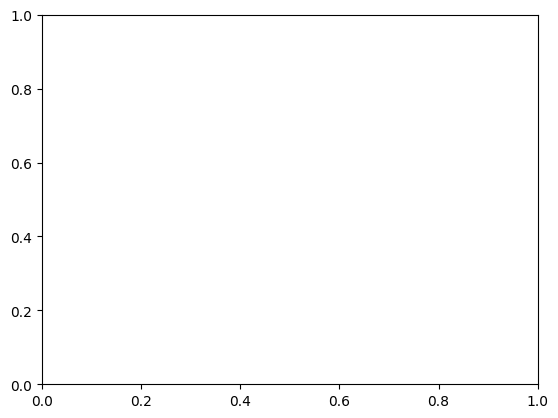

In [ ]:
# Plot all cts w/o rule names
fig, ax = plt.subplots()
ax.plot(leak_cts, 'k.--')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlabel('rule rank')
ax.set_ylabel('# reactions')
plt.show()

# Plot top n rules
n = 10
fig, ax = plt.subplots()
ax.bar(np.arange(n), leak_cts[:n], tick_label=rule_name[:n])
ax.set_xticklabels(rule_name[:n], rotation=-90)
ax.set_xlabel('rule')
ax.set_ylabel('# reactions')
plt.show()

In [ ]:
sum(leak_cts)

3901

In [27]:
jos_rxns['RXN-7830_reverse']

[{'CPD-7144:0': 'C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3cc4c(O)cc(O)cc4[o+]c3-c3ccc(O)cc3)[C@H](O)[C@@H](O)[C@@H]2O)[C@H](O)[C@H](O)[C@H]1O',
  'UDP:0': 'O=c1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)[nH]1'},
 {'PELARGONIDIN-3-GLUCOSIDE-CMPD:0': 'OC[C@H]1O[C@@H](Oc2cc3c(O)cc(O)cc3[o+]c2-c2ccc(O)cc2)[C@H](O)[C@@H](O)[C@@H]1O',
  'UDP-L-RHAMNOSE:0': 'C[C@@H]1O[C@H](OP(=O)(O)OP(=O)(O)OC[C@H]2O[C@@H](n3ccc(=O)[nH]c3=O)[C@H](O)[C@@H]2O)[C@H](O)[C@H](O)[C@H]1O'},
 '',
 'rule0001']

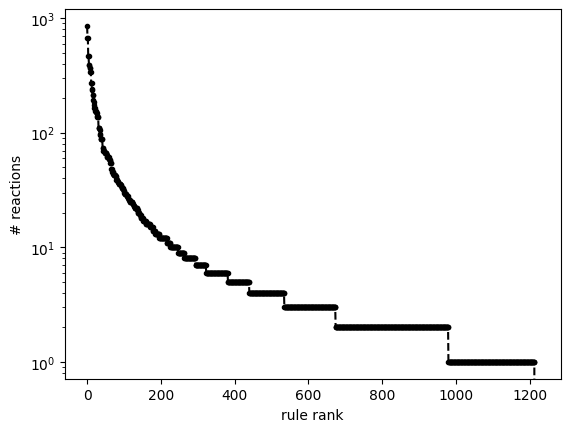

Mean rxns mapped: 14.879901960784315


In [32]:
# Plot reaction counts by rule
rule2rxn = {}
for k,v in jos_mapped.items():
    if v not in rule2rxn:
        rule2rxn[v] = [k]
    else:
        rule2rxn[v].append(k)

rule_ids = list(rule2rxn.keys())
n_rxns_by_rule = [len(elt) for elt in rule2rxn.values()]
rules_rxn_ct_sorted = [[elt[1], elt[0]] for elt in sorted(zip(n_rxns_by_rule, rule_ids), reverse=True)]

# Find rules not in mapping
for elt in all_rules:
    if elt not in rule_ids:
        rules_rxn_ct_sorted.append([elt, 0]) # Tack on with n_rxns=0

rules, rxn_cts = list(zip(*rules_rxn_ct_sorted)) # Sort cts and rule names together

# Order rules by those that contribute the maximum
# number of "new" reactions to the mapping pool as possible
mapping_pool = set()
max_delta_sorted = [] # Reactions sorted by contribution to the mapping pool
deltas = []
search_space = all_rules.copy()

# Plot all cts w/o rule names
fig, ax = plt.subplots()
ax.plot(rxn_cts, 'k.--')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlabel('rule rank')
ax.set_ylabel('# reactions')
plt.show()
print("Mean rxns mapped: {}".format(sum(rxn_cts) / len(rxn_cts)))

# Characterize rules by EC

In [51]:
rule2ecs = {}
for i, elt in enumerate(mapped_rxns): # Iterate over mapped, unmapped lists

    if elt in filtered_rxns_w_ec.keys():
        this_ec = filtered_rxns_w_ec[elt]
        this_ec = this_ec[0].lstrip('|EC-').rstrip('|').split('.')

        this_rules = rxn2rule[elt] # Rules that mapped this rxn

        for elt2 in this_rules:
            if elt2 not in rule2ecs:
                rule2ecs[elt2] = [] # List of lists
                rule2ecs[elt2].append(['.'.join(this_ec[0])]) # First digit
                rule2ecs[elt2].append(['.'.join(this_ec[:2])]) # Second digit
                rule2ecs[elt2].append(['.'.join(this_ec[:3])]) # Third digit
                rule2ecs[elt2].append(['.'.join(this_ec)]) # Full EC
            else:
                rule2ecs[elt2][0].append('.'.join(this_ec[0])) # First digit
                rule2ecs[elt2][1].append('.'.join(this_ec[:2])) # Second digit
                rule2ecs[elt2][2].append('.'.join(this_ec[:3])) # third digit
                rule2ecs[elt2][3].append('.'.join(this_ec)) # Full EC

# Count
temp = {}
for k, v in rule2ecs.items():
    temp[k] = [dict(Counter(elt)) for elt in v]
rule2ecs = temp

# Sort according to mappiest
temp = {}
for elt in rules:
    if elt in rule2ecs.keys():
        temp[elt] = rule2ecs[elt]
rule2ecs = temp

len(rule2ecs.keys())

609

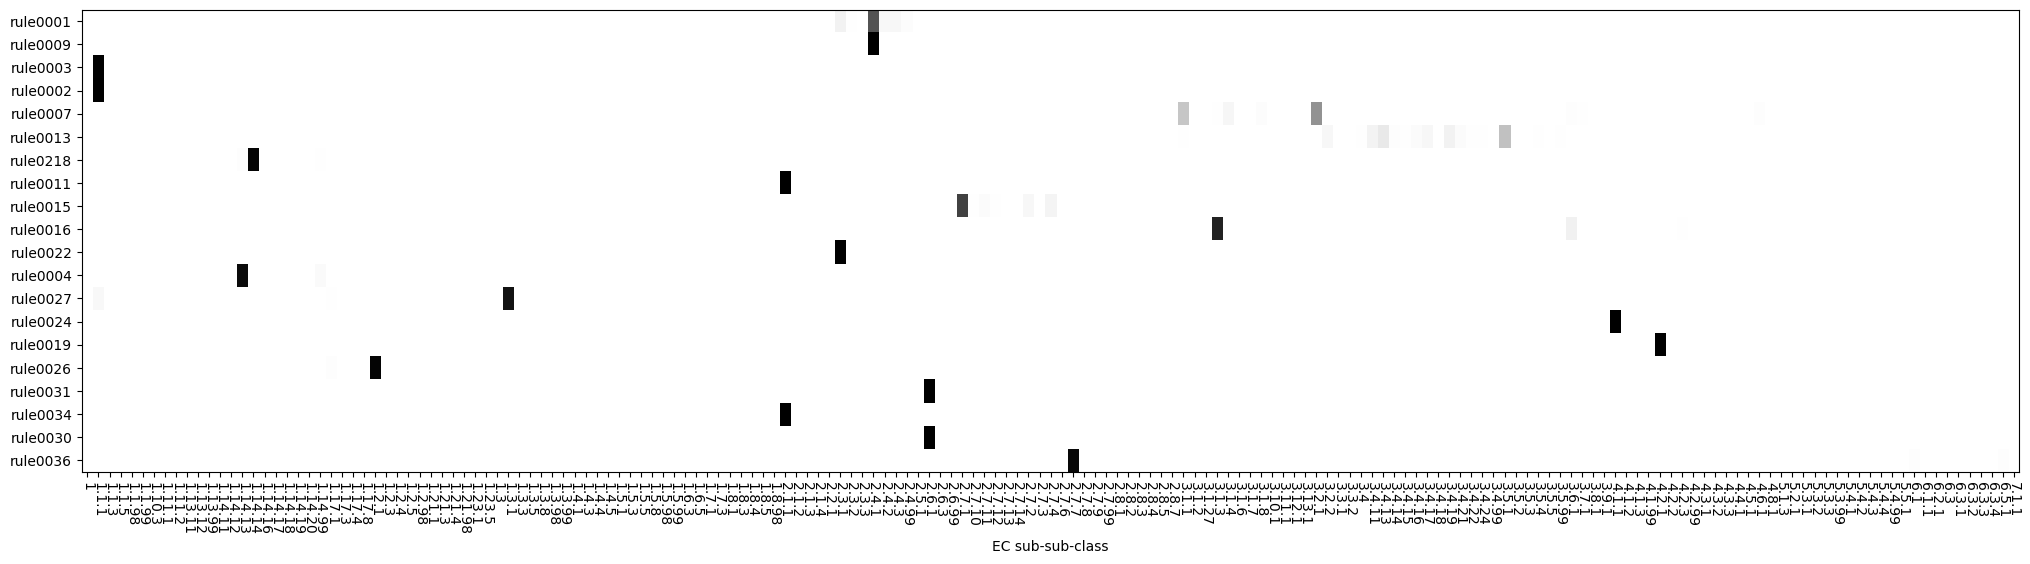

In [52]:
n = 20 # Plot top n
rules_w_ec = list(rule2ecs.keys())

# Get all ECs at some digit level
level = 2 # Zero indexed
digits = []
for k, v in rule2ecs.items():
    digits += list(v[level].keys())

digits = sorted(list(set(digits)))

digit_cts = []
for i, elt in enumerate(rule2ecs.keys()):
    digit_cts.append([])
    for elt2 in digits:
        if elt2 in rule2ecs[elt][level]:
            digit_cts[i].append(rule2ecs[elt][level][elt2])
        else:
            digit_cts[i].append(0)

digit_cts = np.array(digit_cts)
digit_cts = digit_cts / digit_cts.sum(axis=1).reshape(-1,1)
# digit_cts = np.nan_to_num(digit_cts)

top_n_digit_cts = digit_cts[:n]
top_n_rules = rules_w_ec[:n]

fig, ax = plt.subplots(figsize=(25,6))
ax.imshow(top_n_digit_cts, vmin=0, vmax=1, cmap='Greys', aspect='auto')
ax.set_xticks(np.arange(len(digits)))
ax.set_xticklabels(digits, rotation=-90)
ax.set_yticks(np.arange(len(top_n_rules)))
ax.set_yticklabels(top_n_rules)
ax.set_xlabel('EC sub-sub-class')
plt.show()

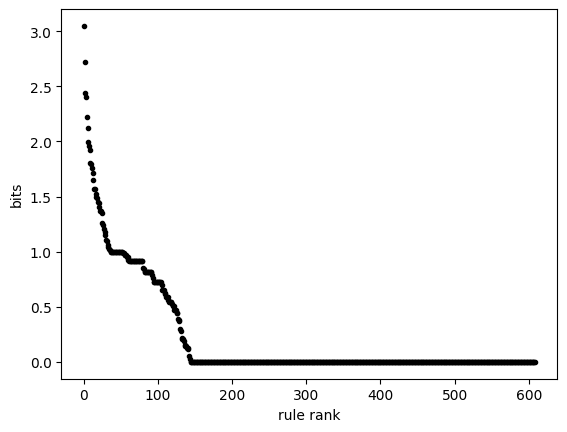

In [53]:
# Look at entropy of third digit ec distributions

def info(arr):
    nonzero_arr = arr[arr > 0]
    nonzero_arr = -nonzero_arr * np.log2(nonzero_arr)
    arr[arr > 0] = nonzero_arr
    return arr

# foo = entr(digit_cts).sum(axis=1)
entropy = info(digit_cts).sum(axis=1)

entropy, rules_w_ec, digit_cts = list(zip(*sorted(list(zip(entropy, rules_w_ec, digit_cts)), reverse=True)))
digit_cts = np.array(digit_cts)

fig, ax = plt.subplots()
ax.plot(entropy, 'k.')
ax.set_ylabel('bits')
ax.set_xlabel('rule rank')
# ax.set_xticks(np.arange(len(rules_w_ec)))
# ax.set_xticklabels(rules_w_ec, rotation=-90)
plt.show()

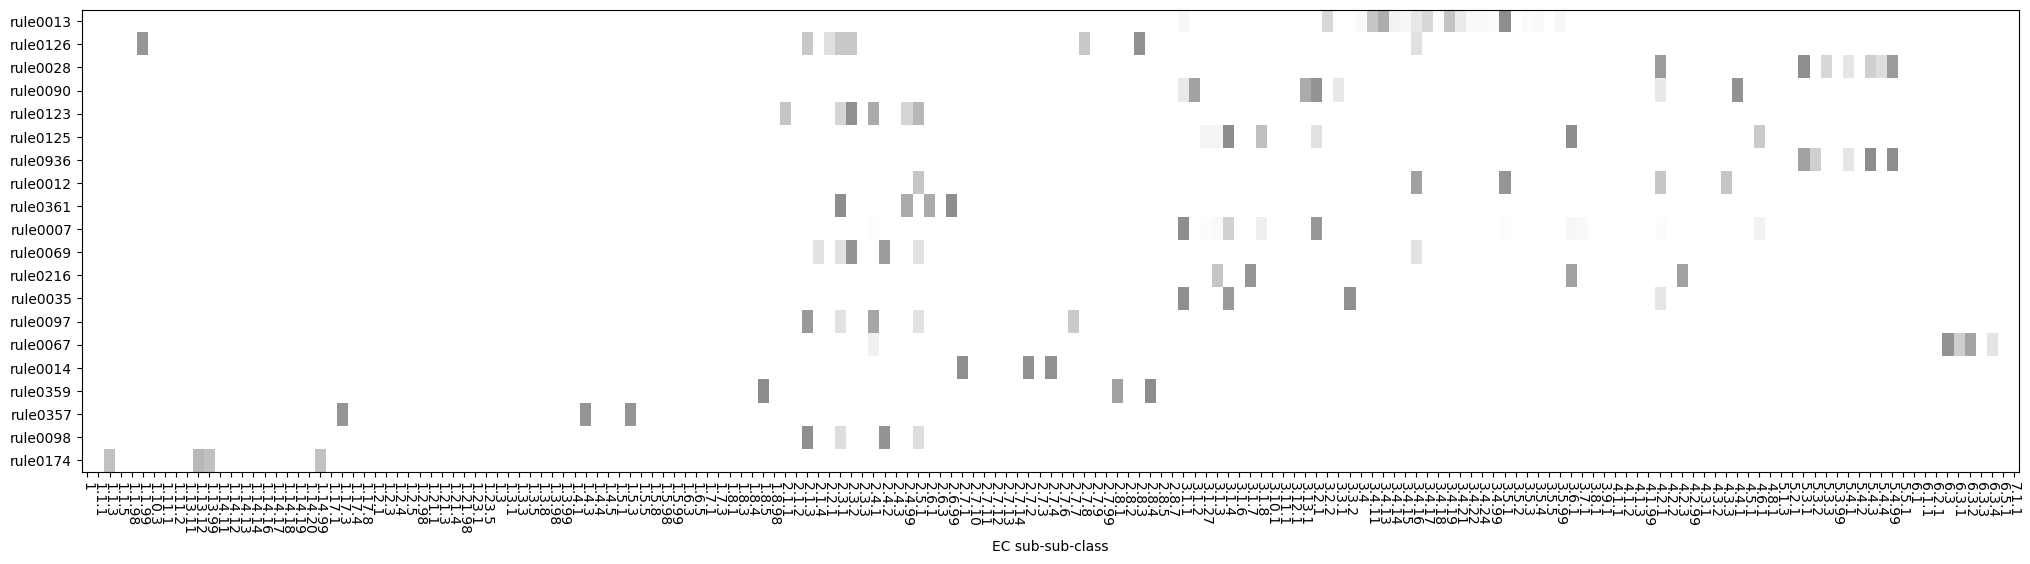

In [54]:
top_n_digit_cts = digit_cts[:n]
top_n_rules = rules_w_ec[:n]

fig, ax = plt.subplots(figsize=(25,6))
ax.imshow(top_n_digit_cts, vmin=0, vmax=1, cmap='Greys', aspect='auto')
ax.set_xticks(np.arange(len(digits)))
ax.set_xticklabels(digits, rotation=-90)
ax.set_yticks(np.arange(len(top_n_rules)))
ax.set_yticklabels(top_n_rules)
ax.set_xlabel('EC sub-sub-class')
plt.show()

In [ ]:
# # Pull metacyc ec descriptions
# n_entries = 33995 # Total number of compounds on seed as of 11/15/2022
# transport_super_path = "https://metacyc.org/META/ajax-direct-subs?object=Transport-Reactions"
# group_translocation_path = 'https://metacyc.org/META/ajax-direct-subs?object=TR-14'
# diffusion_path = 'https://metacyc.org/META/ajax-direct-subs?object=TR-21'
# trans_e_decarb_path = 'https://metacyc.org/META/ajax-direct-subs?object=TR-15'
# trans_e_phosphoanhyd_path = 'https://metacyc.org/META/ajax-direct-subs?object=TR-13'
# trans_e_membrane_echem_grad_path = 'https://metacyc.org/META/ajax-direct-subs?object=TR-12'
# tonb_path = 'https://metacyc.org/META/ajax-direct-subs?object=TR-20'
# trans_fac_channels_path = 'https://metacyc.org/META/ajax-direct-subs?object=TR-11'
# trans_unk_path = 'https://metacyc.org/META/ajax-direct-subs?object=TR-19'

# paths = [transport_super_path, group_translocation_path, diffusion_path, trans_e_decarb_path,
#          trans_e_phosphoanhyd_path, trans_e_membrane_echem_grad_path, tonb_path,
#          trans_fac_channels_path, trans_unk_path]

# # Pull down data into json objects
# jsons = []
# for path in paths:
#     jsons.append(requests.get(path).json())

# Store table with rule | top 1st digit | top second digit | second second digit...

# Store table structured similarly with rule | top class name | top subclass | second subclass...

In [55]:
srt_by_name = sorted(rules_w_ec)
header = ['rule', 'top_1st_digit', 'top_2nd_digit', 'top_3rd_digit']
save_to = 'min_rules_top_ec_numbers.csv'

to_csv = []
for elt in srt_by_name:
    row = [elt]
    for i in range(3):
        this_top = ''
        this_max = 0
        for k,v in rule2ecs[elt][i].items():
            if v > this_max:
                this_top = k
                this_max = v
        row.append(this_top)
    to_csv.append(row)
    

with open(save_to, 'w') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(header)
    writer.writerows(to_csv)

# Full intermediate mapping

In [60]:
# Load mapping

all_rxns = []
mapped_rxns = []
unmapped_rxns = []
rxn2rule = {}

db_names = ['_mc_v21', '_brenda', '_kegg']
suffix = '_imt_rules_enforce_cof.csv'
for name in db_names:
    mapping_path = '../mapping/results/mapping' + name + suffix
    with open(mapping_path, 'r') as f:
        reader = csv.reader(f)
        k = 0
        for row in reader:
            all_rxns.append(row[0])
            if len(row) == 1:
                unmapped_rxns.append(row[0])
                rxn2rule[row[0]] = []
            else:
                mapped_rxns.append(row[0])
                rxn2rule[row[0]] = row[1:]
            k += 1
    print(k)

    # print(len(all_rxns))

print("Mapping fraction: {}".format(len(mapped_rxns) / len(all_rxns)))
print("Total # reactions analyzed: {}".format(len(all_rxns)))

21852
56008
12990
Mapping fraction: 0.72
Total # reactions analyzed: 90850


In [8]:
# kegg = load_json('/home/stef/Tb/reaction_mapping/mapping/kegg_as_is.json')
# brenda = load_json('/home/stef/Tb/reaction_mapping/mapping/brenda_as_is.json')
# mc21 = load_json('/home/stef/Tb/reaction_mapping/mapping/mc_v21_as_is.json')
# print(len(mc21), len(brenda), len(kegg))
# print(len(mc21) + len(brenda) + len(kegg))

22036 56008 12990
91034


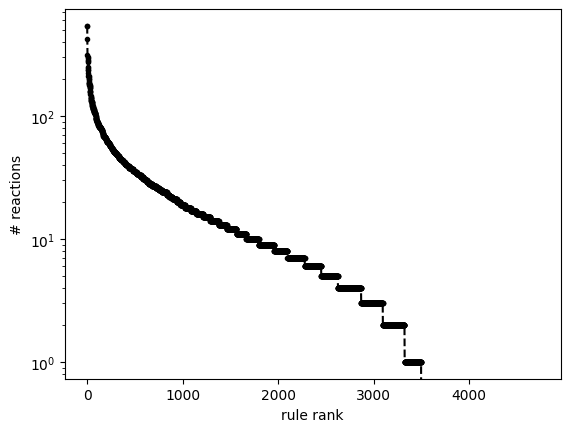

Mean rxns mapped: 14.669349714043635


In [61]:
rule2rxn = {}
for k,v in rxn2rule.items():
    for elt in v:
        if elt not in rule2rxn:
            rule2rxn[elt] = [k]
        else:
            rule2rxn[elt].append(k)

rule_ids = list(rule2rxn.keys())
n_rxns_by_rule = [len(elt) for elt in rule2rxn.values()]
rules_rxn_ct_sorted = [[elt[1], elt[0]] for elt in sorted(zip(n_rxns_by_rule, rule_ids), reverse=True)]

# Find rules not in mapping
for elt in all_rules:
    if elt not in rule_ids:
        rules_rxn_ct_sorted.append([elt, 0]) # Tack on with n_rxns=0

rules, rxn_cts = list(zip(*rules_rxn_ct_sorted)) # Sort cts and rule names together

# Plot all cts w/o rule names
fig, ax = plt.subplots()
ax.plot(rxn_cts, 'k.--')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlabel('rule rank')
ax.set_ylabel('# reactions')
plt.show()
print("Mean rxns mapped: {}".format(sum(rxn_cts) / len(rxn_cts)))

In [17]:
non_mappers = rules[rxn_cts.index(0):]
print(len(rules), len(non_mappers))
non_mappers

3604 107


('rule0001_36',
 'rule0001_39',
 'rule0006_027',
 'rule0006_037',
 'rule0006_139',
 'rule0008_02',
 'rule0008_41',
 'rule0012_015',
 'rule0012_019',
 'rule0012_021',
 'rule0012_034',
 'rule0012_035',
 'rule0012_041',
 'rule0012_047',
 'rule0012_062',
 'rule0012_075',
 'rule0012_076',
 'rule0012_077',
 'rule0012_079',
 'rule0012_093',
 'rule0012_096',
 'rule0012_100',
 'rule0012_101',
 'rule0012_106',
 'rule0012_109',
 'rule0012_110',
 'rule0012_116',
 'rule0012_123',
 'rule0012_124',
 'rule0012_126',
 'rule0012_128',
 'rule0012_132',
 'rule0012_140',
 'rule0012_141',
 'rule0012_145',
 'rule0012_149',
 'rule0012_160',
 'rule0012_161',
 'rule0012_163',
 'rule0012_165',
 'rule0012_166',
 'rule0012_168',
 'rule0012_183',
 'rule0012_185',
 'rule0012_188',
 'rule0012_190',
 'rule0012_192',
 'rule0012_197',
 'rule0012_199',
 'rule0012_201',
 'rule0012_202',
 'rule0012_204',
 'rule0012_205',
 'rule0012_212',
 'rule0012_215',
 'rule0012_230',
 'rule0012_234',
 'rule0012_235',
 'rule0012_237',
 

In [21]:
mystery_imt = pd.read_csv('/home/stef/Tb/reaction_mapping/metacyc_intermediate_rules.tsv', delimiter='\t')
mystery_imt.head()

,Name,Reactants,SMARTS,Products,Comments,counts,Uniprot
0,rule0012_18,Any;Any,[#6;$([#6&!R](-&!@[#6&!R]-&!@[#7&!R]-&!@[#6&!R...,Any;WATER,brenda:3.4.11.4_00;brenda:3.4.11.4_01;brenda:3...,989,A1S3N8;AB009494;AKR1C2;ALDH3A1;ALDH7A1;AMADH2;...
1,rule0003_13,NADH_CoF;Any,[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[#6:5]-[#6:6]-1.[...,Any;NAD_CoF,brenda:1.1.1.100_17;brenda:1.1.1.102_1;brenda:...,424,A0A017H563;A0A017HPK1;A0A017IAF0;A0A023PAM9;A0...
2,rule0012_12,Any;Any,[#6;$([#6&!R](-&!@[#6&!R]-&!@[#7&!R]-&!@[#6&!R...,Any;WATER,brenda:3.4.11.10_013;brenda:3.4.11.2_024;brend...,405,A0A097BW92;A0A097BW98;A0A0C5PRQ1;A4UWM5;A6Y9U8...
3,rule0012_23,Any;Any,[#6;$([#6&!R](-&!@[#6&!R])=&!@[#8&!R]);!$([#6&...,Any;WATER,brenda:3.4.11.10_055;brenda:3.4.11.10_058;bren...,400,A0A1D8PKD2;A0AHD2;A0JMS7;A0MTQ2;A0RHZ2;A2BP19;...
4,rule0010_4,METHYL_ACCEPTOR_CoF;Any,[#16:1].[#6:2]-[#8;$([#8&!R]-&!@[#6&R]1:&@[#6&...,METHYL_DONOR_CoF;Any,brenda:2.1.1.104_01;brenda:2.1.1.104_06;brenda...,394,A0A024FR43;A0A088B191;A0A0K1YW34;A1DA61;A1Y9I9...


In [24]:
mystery_rules = mystery_imt['Name'].to_list()
len(mystery_rules)

7358

In [25]:
all_rules

['rule0001_01',
 'rule0001_02',
 'rule0001_03',
 'rule0001_04',
 'rule0001_05',
 'rule0001_06',
 'rule0001_07',
 'rule0001_08',
 'rule0001_09',
 'rule0001_10',
 'rule0001_11',
 'rule0001_12',
 'rule0001_13',
 'rule0001_14',
 'rule0001_15',
 'rule0001_16',
 'rule0001_17',
 'rule0001_18',
 'rule0001_19',
 'rule0001_20',
 'rule0001_21',
 'rule0001_22',
 'rule0001_23',
 'rule0001_24',
 'rule0001_25',
 'rule0001_26',
 'rule0001_27',
 'rule0001_28',
 'rule0001_29',
 'rule0001_30',
 'rule0001_31',
 'rule0001_32',
 'rule0001_33',
 'rule0001_34',
 'rule0001_35',
 'rule0001_36',
 'rule0001_37',
 'rule0001_38',
 'rule0001_39',
 'rule0001_40',
 'rule0001_41',
 'rule0001_42',
 'rule0001_43',
 'rule0001_44',
 'rule0001_45',
 'rule0001_46',
 'rule0001_47',
 'rule0001_48',
 'rule0001_49',
 'rule0001_50',
 'rule0001_51',
 'rule0001_52',
 'rule0001_53',
 'rule0001_54',
 'rule0001_55',
 'rule0001_56',
 'rule0001_57',
 'rule0001_58',
 'rule0001_59',
 'rule0001_60',
 'rule0001_61',
 'rule0001_62',
 'rule00

In [39]:
{(1,2)} | {(1,2), (2,2)}
tup_rules = []
for elt in [all_rules, rules, mystery_rules]:
    temp = []
    for subelt in elt:
        subelt = subelt.split('_')
        if len(subelt) == 2:
            tup = (int(subelt[0].lstrip('rule')), int(subelt[1]))
        elif len(subelt) == 1:
            tup = (int(subelt[0].lstrip('rule')),)
        temp.append(tup)

    tup_rules.append(temp)


a, r, m = tup_rules

0
1
2


In [51]:
set(r[rxn_cts.index(0):]) & set(m)

{(8, 2),
 (8, 41),
 (12, 15),
 (12, 19),
 (12, 21),
 (12, 34),
 (12, 35),
 (16, 70),
 (28, 31),
 (32, 20),
 (32, 31),
 (32, 32),
 (32, 34),
 (65, 11),
 (168, 6),
 (230, 3),
 (319, 2),
 (355, 1),
 (390, 2),
 (467, 2),
 (473, 2),
 (597, 2),
 (615, 2)}

In [52]:
set(r[:rxn_cts.index(0)]) & set(m)

{(31, 6),
 (200, 2),
 (43, 3),
 (7, 25),
 (16, 47),
 (182, 1),
 (34, 8),
 (108, 7),
 (15, 30),
 (37, 13),
 (24, 14),
 (120, 2),
 (247, 1),
 (13, 20),
 (74, 2),
 (3, 2),
 (213, 2),
 (8, 38),
 (7, 22),
 (16, 38),
 (404, 2),
 (80, 3),
 (9, 9),
 (34, 3),
 (790, 1),
 (59, 9),
 (24, 21),
 (62, 6),
 (13, 13),
 (74, 13),
 (3, 11),
 (28, 1),
 (53, 7),
 (40, 4),
 (7, 15),
 (16, 29),
 (22, 7),
 (5, 53),
 (34, 26),
 (145, 5),
 (24, 28),
 (244, 2),
 (62, 9),
 (13, 6),
 (383, 2),
 (25, 3),
 (99, 4),
 (210, 1),
 (28, 24),
 (321, 2),
 (7, 4),
 (16, 20),
 (472, 1),
 (19, 1),
 (5, 62),
 (118, 2),
 (47, 2),
 (12, 32),
 (34, 21),
 (17, 43),
 (241, 2),
 (59, 7),
 (13, 63),
 (25, 4),
 (53, 9),
 (386, 2),
 (78, 3),
 (16, 11),
 (201, 1),
 (19, 6),
 (5, 39),
 (44, 6),
 (17, 44),
 (56, 1),
 (37, 33),
 (183, 6),
 (352, 2),
 (10, 5),
 (84, 12),
 (195, 3),
 (13, 56),
 (491, 2),
 (96, 7),
 (25, 13),
 (334, 1),
 (121, 1),
 (53, 18),
 (4, 7),
 (78, 10),
 (1164, 1),
 (7, 122),
 (16, 2),
 (143, 1),
 (19, 15),
 (2, 45),

In [44]:
overlap = list(set(a) & set(m))
print(overlap[0])

(31, 6)


In [46]:
m31_6 = '[#6:1]-[#7:2].[#6;$([#6&R]1-&@[#6&R]-&@[#6&R]-&@[#6&R](-&@[#8&R]-&@[#6&R]-&@1)-&!@[#8&!R]-&!@[#15&!R](-&!@[#8&!R]-&!@[#15&!R](-&!@[#8&!R]-&!@[#6&!R]-&!@[#6&R]1-&@[#6&R](-&@[#6&R]-&@[#6&R](-&@[#8&R]-&@1)-&!@[#7&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R](:&@[#7&R]:&@[#6&R]:&@1=&!@[#8&!R])=&!@[#8&!R])-&!@[#8&!R])(=&!@[#8&!R])-&!@[#8&!R])(=&!@[#8&!R])-&!@[#8&!R]);!$([#6&R]1-&@[#6&R](-&@[#8&R]-&@[#6&R](-&@[#6&R](-&@[#6&R]-&@1-&!@[#8&!R])-&!@[#7&!R]-&!@[#6&!R](-&!@[#6&!R])=&!@[#8&!R])-&!@[#8&!R]-&!@[#15&!R](=&!@[#8&!R])(-&!@[#8&!R])-&!@[#8&!R]-&!@[#15&!R](=&!@[#8&!R])(-&!@[#8&!R])-&!@[#8&!R]-&!@[#6&!R]-&!@[#6&R]1-&@[#8&R]-&@[#6&R](-&@[#6&R](-&@[#6&R]-&@1-&!@[#8&!R])-&!@[#8&!R])-&!@[#7&R])-&!@[#6&!R]):3]=[#8:4]>>[#6:3]-[#7:2].[#6:1]=[#8:4]'
a31_6 = '[#6:1]-[#7:2].[#6;$([#6&!R]-&!@[#6&!R]-&!@[#6&!R]);!$([#6&!R](-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R])-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R]);!$([#6&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R]):3]=[#8:4]>>[#6:3]-[#7:2].[#6:1]=[#8:4]'
m31_6 == a31_6

False

In [49]:
rxn = AllChem.ReactionFromSmarts(m31_6)
d2d = Draw.MolDraw2DCairo(800,300)
d2d.DrawReaction(rxn)
png = d2d.GetDrawingText()
open('./m31_6.png','wb+').write(png)

rxn = AllChem.ReactionFromSmarts(a31_6)
d2d = Draw.MolDraw2DCairo(800,300)
d2d.DrawReaction(rxn)
png = d2d.GetDrawingText()
open('./a31_6.png','wb+').write(png)

7545

# Scrap

In [ ]:
test = {elt:filtered_mc_rxns[elt] for elt in fn}
save_json(test, '/home/stef/Tb/reaction_mapping/mapping/false_negatives.json')

In [ ]:
max_products = 1000
rxnid = 'RXN-14519' # 'RXN-11842'
reactants = sanitize(list(filtered_mc_rxns[rxnid][0].values()))
products = sanitize(list(filtered_mc_rxns[rxnid][1].values()))
rule = '[#16:1].[#6:2]-[#7:3]>>[#6:2]-[#16+:1].[#7:3]' # '([#6:1].[#6:2]-[#7:3])>>([#7:3].[#6:1]-[#6:2])' 
operator = Chem.rdChemReactions.ReactionFromSmarts(rule) # Make reaction object from smarts string
reactants_mol = tuple([Chem.MolFromSmiles(elt) for elt in reactants]) # Convert reactant smiles to mol obj
outputs = operator.RunReactants(reactants_mol, maxProducts=max_products)
outputs_smis = [[m2s(elt2) for elt2 in elt] for elt in outputs]


In [ ]:
for elt in outputs_smis:
    mapped = len(set(products) - set(elt)) == 0
    print(mapped)

False
False
False


In [ ]:
outputs_smis

[['*OP(=O)(O)OCC1OC([S+](CCC(N)C(=O)O)CC2OC(n3cnc4c(N)ncnc43)C(O)C2O)C(O)C1OP(=O)(O)O*',
  'Cc1nc2n(C)c3ncnc3c(=O)n2c1CCC(N)C(=O)O'],
 ['*OP(=O)(O)OCC1OC(n2cnc3c(=O)n4c(CCC(C(=O)O)[S+](CCC(N)C(=O)O)CC5OC(n6cnc7c(N)ncnc76)C(O)C5O)c(C)nc4n(C)c32)C(O)C1OP(=O)(O)O*',
  'N'],
 ['C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O',
  '*OP(=O)(O)OCC1OC(n2cnc3c(=O)n4c(CCC(N)C(=O)O)c(C)nc4nc32)C(O)C1OP(=O)(O)O*']]

In [ ]:
for output in outputs_smis:
    san_smi_outputs = postsanitize_smiles(outputs_smis[2])
    for elt in san_smi_outputs:
        mapped = len(set(products) - set(elt)) == 0
        if mapped:
            print(elt)

NameError: name 'postsanitize_smiles' is not defined

In [ ]:
san_smi_outputs

[('C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O',
  '*OP(=O)(O)OCC1OC(n2cnc3c(=O)n4c(CCC(N)C(=O)O)c(C)[nH]c4nc32)C(O)C1OP(=O)(O)O*'),
 ('C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O',
  '*OP(=O)(O)OCC1OC(n2cnc3c(=O)n4c(CCC(N)C(=O)O)c(C)nc4[nH]c32)C(O)C1OP(=O)(O)O*')]

In [ ]:
for elt in san_smi_outputs[0]:
    if elt == products[0]:
        print(elt)

*OP(=O)(O)OCC1OC(c2c[nH]c(=O)[nH]c2=O)C(O)C1OP(=O)(O)O*


In [ ]:
san_smi_outputs[0][-1]

'O'

In [ ]:
def postsanitize_smiles(smiles_list):
    """Postsanitize smiles after running SMARTS.
    :returns tautomer list of list of smiles"""

    sanitized_list = []
    tautomer_smarts = '[#7H1X3&a:1]:[#6&a:2]:[#7H0X2&a:3]>>[#7H0X2:1]:[#6:2]:[#7H1X3:3]'

    for s in smiles_list:

        temp_mol = Chem.MolFromSmiles(s, sanitize=False)
        aromatic_bonds = [i.GetIdx() for i in temp_mol.GetBonds() if i.GetBondType() == Chem.rdchem.BondType.AROMATIC]

        for i in temp_mol.GetBonds():
            if i.GetBondType() == Chem.rdchem.BondType.UNSPECIFIED:
                i.SetBondType(Chem.rdchem.BondType.SINGLE)

        try:
            Chem.SanitizeMol(temp_mol)
            Chem.rdmolops.RemoveStereochemistry(temp_mol)
            temp_smiles = Chem.MolToSmiles(temp_mol)

        except Exception as msg:
            if 'Can\'t kekulize mol' in str(msg):
                pyrrole_indices = [i[0] for i in temp_mol.GetSubstructMatches(Chem.MolFromSmarts('n'))]

                # indices to sanitize
                for s_i in pyrrole_indices:
                    temp_mol = Chem.MolFromSmiles(s, sanitize=False)
                    if temp_mol.GetAtomWithIdx(s_i).GetNumExplicitHs() == 0:
                        temp_mol.GetAtomWithIdx(s_i).SetNumExplicitHs(1)
                    elif temp_mol.GetAtomWithIdx(s_i).GetNumExplicitHs() == 1:
                        temp_mol.GetAtomWithIdx(s_i).SetNumExplicitHs(0)
                    try:
                        Chem.SanitizeMol(temp_mol)

                        processed_pyrrole_indices = [i[0] for i in
                                                     temp_mol.GetSubstructMatches(Chem.MolFromSmarts('n'))]
                        processed_aromatic_bonds = [i.GetIdx() for i in
                                                    temp_mol.GetBonds() if i.GetBondType() == Chem.rdchem.BondType.AROMATIC]
                        if processed_pyrrole_indices != pyrrole_indices or aromatic_bonds != processed_aromatic_bonds:
                            continue

                        Chem.rdmolops.RemoveStereochemistry(temp_mol)
                        temp_smiles = Chem.MolToSmiles(temp_mol)
                        break
                    except:
                        continue
                if 'temp_smiles' not in vars():
                    Chem.rdmolops.RemoveStereochemistry(temp_mol)
                    temp_smiles = Chem.MolToSmiles(temp_mol)
                    sanitized_list.append([temp_smiles])
                    continue
            else:
                Chem.rdmolops.RemoveStereochemistry(temp_mol)
                temp_smiles = Chem.MolToSmiles(temp_mol)
                sanitized_list.append([temp_smiles])
                continue
        rxn = AllChem.ReactionFromSmarts(tautomer_smarts)

        try:
            tautomer_mols = rxn.RunReactants((Chem.MolFromSmiles(temp_smiles), ))
        except:
            try:
                tautomer_mols = rxn.RunReactants((Chem.MolFromSmiles(temp_smiles, sanitize=False),))
            except:
                continue

        tautomer_smiles = [Chem.MolToSmiles(m[0]) for m in tautomer_mols]
        sanitized_list.append(sorted(set(tautomer_smiles + [temp_smiles])))

    return list(itertools.product(*sanitized_list))